# Mock Data

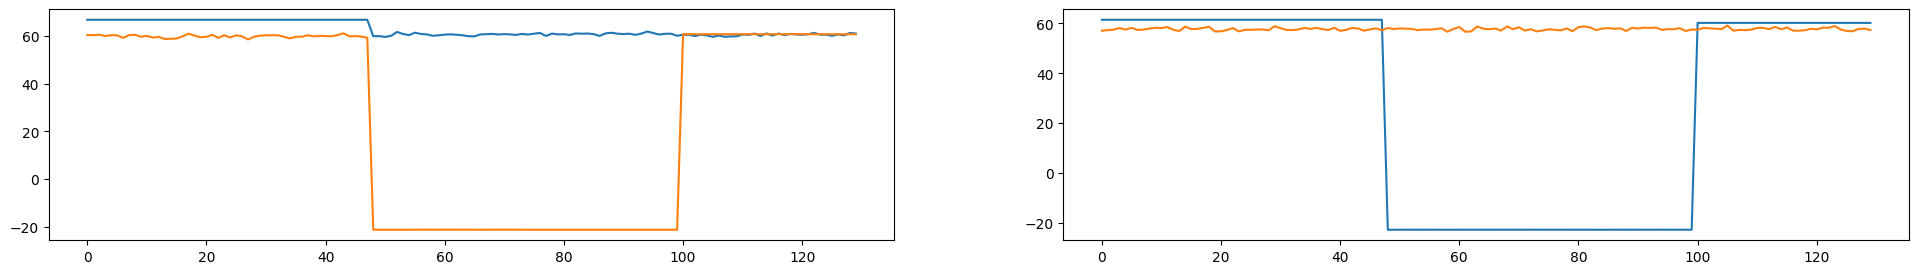

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
def normal_data_generator():
    # 第一段 48分鐘
    base = float(np.random.normal(60, 2, size = (1, )))
    series1_1 = (np.random.normal(0, .5, size = (48, )) + base).tolist()
    
    base = float(np.random.normal(70, 2, size = (1, )))
    series2_1 = ([base]*48).copy()
    
    # 第二段 52分鐘
    base = float(np.random.normal(-20, 2, size = (1, )))
    series1_2 = (np.random.normal(0, .01, size = (52, )) + base).tolist()
    
    base = float(np.random.normal(60, 2, size = (1, )))
    series2_2 = (np.random.normal(0, .5, size = (52 + 30, )) + base).tolist()
    
    # 第三段 30分鐘
    base = float(np.random.normal(60, 2, size = (1, )))
    series1_3 = ([base]*30).copy()
    
    series1 = series1_1 + series1_2 + series1_3
    series2 = series2_1 + series2_2
    flag = float(np.random.normal(0, .5, size = (1, )))
    if flag > .5:
        return np.vstack([series1, series2]).T
    else:
        return np.vstack([series2, series1]).T

def abnormal_data_generator():
    base = float(np.random.normal(60, 2, size = (1, )))
    series1 = (np.random.normal(0, .5, size = (48+52+30, )) + base).tolist()
    
    base = float(np.random.normal(60, 2, size = (1, )))
    series2_1 = ([base]*48).copy()
    base = float(np.random.normal(-20, 2, size = (1, )))
    series2_2 = (np.random.normal(0, .01, size = (52, )) + base).tolist()
    base = float(np.random.normal(60, 2, size = (1, )))
    series2_3 = ([base]*30).copy()
    series2 = series2_1 + series2_2 + series2_3
    
    flag = float(np.random.normal(0, .5, size = (1, )))
    if flag > .5:
        return np.vstack([series1, series2]).T
    else:
        return np.vstack([series2, series1]).T
    
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize = (24, 3))
ax[0].plot(normal_data_generator())
ax[1].plot(abnormal_data_generator())
plt.show()

# 對比學習

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# 忽略 Matplotlib 的使用者警告
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TSEncoder(nn.Module):
    """
    一個只使用全連接層 (Dense Layers / MLP) 的時間序列編碼器。
    """
    def __init__(self, input_dims=2, sequence_length=130, output_dims=128):
        super().__init__()
        
        # 計算攤平後的輸入維度
        flattened_dims = input_dims * sequence_length # 2 * 130 = 260

        # --- MLP 主體結構 ---
        # 定義一系列的全連接層
        self.mlp_body = nn.Sequential(
            nn.Linear(flattened_dims, 512),
            nn.BatchNorm1d(512), # BatchNorm 對於穩定 MLP 訓練很有幫助
            nn.ReLU(),
            nn.Dropout(0.3), # 使用 Dropout 來防止過擬合

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        # --- 投影頭 (Projector) ---
        # 這部分與之前的設計保持一致，用於對接自監督學習的損失函數
        # MLP 主體輸出的維度是 256
        self.projector = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, output_dims)
        )

    def forward(self, x):
        # 輸入 x 的維度: (batch_size, sequence_length, input_dims)
        # 例如: (64, 130, 2)

        # 1. 關鍵步驟：將時間序列數據攤平
        # (B, 130, 2) -> (B, 130 * 2) = (B, 260)
        x_flattened = x.flatten(start_dim=1)
        
        # 2. 通過 MLP 主體提取特徵
        embedding_feature = self.mlp_body(x_flattened) # -> (B, 256)
        
        # 3. 通過投影頭得到最終的 embedding
        final_embedding = self.projector(embedding_feature) # -> (B, output_dims)
        
        return final_embedding
#########################################################################################################
# class TSEncoder(nn.Module):
#     def __init__(self, input_dims=2, output_dims=128):
#         super().__init__()
#         # input_dims=2 因為有兩個 series
#         self.conv1 = nn.Conv1d(in_channels=input_dims, out_channels=32, kernel_size=8, padding='same')
#         self.bn1 = nn.BatchNorm1d(32)
#         self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, padding='same')
#         self.bn2 = nn.BatchNorm1d(64)
#         self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding='same')
#         self.bn3 = nn.BatchNorm1d(128)
        
#         # 最終輸出的投影頭 (Projection Head)
#         self.projector = nn.Sequential(
#             nn.Linear(128, 256),
#             nn.ReLU(),
#             nn.Linear(256, output_dims)
#         )

#     def forward(self, x):
#         # PyTorch 的 Conv1D 需要 (Batch, Channels, Length)
#         x = x.permute(0, 2, 1)
        
#         x = F.relu(self.bn1(self.conv1(x)))
#         x = F.relu(self.bn2(self.conv2(x)))
#         x = F.relu(self.bn3(self.conv3(x)))
        
#         # Global Average Pooling
#         x = torch.mean(x, dim=2) # (Batch, 128)
        
#         # 通過投影頭得到最終的 embedding
#         embedding = self.projector(x)
        
#         return embedding
#########################################################################################################
# class TSEncoder(nn.Module):
#     def __init__(self, input_dims=2, output_dims=128, dropout_rate=0.2):
#         super().__init__()
#         # 加寬: 32 -> 64, 64 -> 128
#         self.conv1 = nn.Conv1d(in_channels=input_dims, out_channels=64, kernel_size=8, padding='same')
#         self.bn1 = nn.BatchNorm1d(64)
        
#         self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding='same')
#         self.bn2 = nn.BatchNorm1d(128)
        
#         # 加深: 增加第三個卷積層
#         self.conv3 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, padding='same')
#         self.bn3 = nn.BatchNorm1d(128)
        
#         self.dropout = nn.Dropout(dropout_rate)
        
#         # Global Average Pooling 後的維度是 out_channels of the last conv layer
#         self.projector = nn.Sequential(
#             nn.Linear(128, 256),
#             nn.ReLU(),
#             self.dropout, # 在投影頭中也可以加入
#             nn.Linear(256, output_dims)
#         )

#     def forward(self, x):
#         x = x.permute(0, 2, 1)
        
#         x = F.relu(self.bn1(self.conv1(x)))
#         x = self.dropout(x)
        
#         x = F.relu(self.bn2(self.conv2(x)))
#         x = self.dropout(x)

#         x = F.relu(self.bn3(self.conv3(x)))
        
#         # Global Average Pooling
#         x = torch.mean(x, dim=2)
        
#         embedding = self.projector(x)
        
#         return embedding
#########################################################################################################
    
# class TSEncoder(nn.Module):
#     def __init__(self, input_dims=2, hidden_dims=128, num_lstm_layers=2, output_dims=128, dropout_rate=0.2):
#         super().__init__()
#         # CNN 部分作為特徵提取器
#         self.conv1 = nn.Conv1d(in_channels=input_dims, out_channels=64, kernel_size=8, padding='same')
#         self.bn1 = nn.BatchNorm1d(64)
#         self.conv2 = nn.Conv1d(in_channels=64, out_channels=hidden_dims, kernel_size=5, padding='same')
#         self.bn2 = nn.BatchNorm1d(hidden_dims)
        
#         # LSTM 部分處理時序關係
#         # batch_first=True 讓輸入的 shape 為 (batch, seq_len, features)
#         self.lstm = nn.LSTM(input_size=hidden_dims, 
#                             hidden_size=hidden_dims, 
#                             num_layers=num_lstm_layers, 
#                             batch_first=True,
#                             bidirectional=True) # 使用雙向LSTM可以捕捉前後文資訊
        
#         self.dropout = nn.Dropout(dropout_rate)
        
#         # 雙向 LSTM 的輸出維度是 2 * hidden_dims
#         self.projector = nn.Sequential(
#             nn.Linear(hidden_dims * 2, 256),
#             nn.ReLU(),
#             self.dropout,
#             nn.Linear(256, output_dims)
#         )

#     def forward(self, x):
#         # Input x: (batch, seq_len, features)
#         x = x.permute(0, 2, 1) # -> (batch, features, seq_len) for Conv1D
        
#         # CNN Part
#         x = F.relu(self.bn1(self.conv1(x)))
#         x = F.relu(self.bn2(self.conv2(x)))
        
#         # Prepare for LSTM
#         x = x.permute(0, 2, 1) # -> (batch, seq_len, cnn_output_features)
        
#         # LSTM Part
#         # out: (batch, seq_len, num_directions * hidden_size)
#         # (h_n, c_n): last hidden and cell states
#         out, (h_n, c_n) = self.lstm(x)
        
#         # 我們取 LSTM 最後一個時間步的隱藏狀態作為整個序列的表示
#         # h_n shape: (num_layers * num_directions, batch, hidden_size)
#         # 我們需要合併雙向的結果
#         last_hidden_state = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1) # (batch, 2 * hidden_size)
        
#         embedding = self.projector(last_hidden_state)
        
#         return embedding

#########################################################################################################
# import math

# class PositionalEncoding(nn.Module):
#     def __init__(self, d_model, max_len=500):
#         super().__init__()
#         position = torch.arange(max_len).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
#         pe = torch.zeros(max_len, 1, d_model)
#         pe[:, 0, 0::2] = torch.sin(position * div_term)
#         pe[:, 0, 1::2] = torch.cos(position * div_term)
#         self.register_buffer('pe', pe)

#     def forward(self, x):
#         # x shape: (seq_len, batch_size, d_model)
#         x = x + self.pe[:x.size(0)]
#         return x

# class TSEncoder(nn.Module):
#     def __init__(self, input_dims=2, d_model=128, nhead=4, num_encoder_layers=2, output_dims=128, dropout_rate=0.2):
#         super().__init__()
#         self.d_model = d_model
        
#         # 一個線性層將輸入維度轉換為 d_model
#         self.input_proj = nn.Linear(input_dims, d_model)
        
#         self.pos_encoder = PositionalEncoding(d_model)
        
#         encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
#         self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
#         self.projector = nn.Sequential(
#             nn.Linear(d_model, 256),
#             nn.ReLU(),
#             nn.Dropout(dropout_rate),
#             nn.Linear(256, output_dims)
#         )

#     def forward(self, x):
#         # x shape: (batch, seq_len, features)
#         x = self.input_proj(x) # -> (batch, seq_len, d_model)
        
#         # 使用 batch_first=True
#         x = self.transformer_encoder(x)
        
#         # 我們取序列輸出的平均值作為全局表示
#         x = x.mean(dim=1) # (batch, d_model)
        
#         embedding = self.projector(x)
#         return embedding
#########################################################################################################
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class TSEncoder(nn.Module):
#     """
#     一個階層式的 CNN 編碼器，專為具有分段結構的時間序列設計。
#     """
#     def __init__(self, input_dims=2, output_dims=128):
#         super().__init__()
        
#         # --- 層次 1: 局部特徵提取 ---
#         # 捕捉細微的、高頻的波動模式
#         self.conv_block1 = nn.Sequential(
#             nn.Conv1d(in_channels=input_dims, out_channels=64, kernel_size=3, padding='same'),
#             nn.BatchNorm1d(64),
#             nn.ReLU()
#         )
        
#         # --- 層次 2: 段落級別特徵提取 (核心設計) ---
#         # 使用大 kernel 和大 stride 來捕捉宏觀的、塊狀的特徵
#         self.conv_block2 = nn.Sequential(
#             nn.Conv1d(in_channels=64, out_channels=128, kernel_size=16, stride=8, padding=4), # stride=8 讓它跳躍式前進
#             nn.BatchNorm1d(128),
#             nn.ReLU()
#         )
        
#         # --- 層次 3: 組合宏觀特徵 ---
#         # 在段落級別的特徵之上，進一步組合
#         self.conv_block3 = nn.Sequential(
#             nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding='same'),
#             nn.BatchNorm1d(256),
#             nn.ReLU()
#         )
        
#         # 最終的投影頭 (Projector)，與自監督學習框架對接
#         # 經過 Global Average Pooling 後的維度是最後一層的 out_channels (256)
#         self.projector = nn.Sequential(
#             nn.Linear(256, 256),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(256, output_dims)
#         )

#     def forward(self, x):
#         # 輸入 x 的維度: (batch_size, sequence_length, input_dims)
#         # 例如: (64, 130, 2)
        
#         # 轉換維度以適應 Conv1d: (batch_size, input_dims, sequence_length)
#         x = x.permute(0, 2, 1)
        
#         # 通過各個層次
#         x = self.conv_block1(x) # -> (B, 64, 130)
#         x = self.conv_block2(x) # -> (B, 128, 17)  (L_out = floor((130 + 2*4 - 16)/8 + 1) = 17)
#         x = self.conv_block3(x) # -> (B, 256, 17)
        
#         # 使用 Global Average Pooling 來得到整個序列的固定長度表示
#         # (B, 256, 17) -> (B, 256)
#         embedding_feature = torch.mean(x, dim=2)
        
#         # 通過投影頭得到最終的 embedding
#         final_embedding = self.projector(embedding_feature) # -> (B, output_dims)
        
#         return final_embedding

In [10]:
def nt_xent_loss(z_i, z_j, temperature=0.5):
    """
    NT-Xent Loss 的簡單實現
    z_i, z_j: 正樣本對的 embeddings, shape: [batch_size, embedding_dim]
    """
    batch_size = z_i.shape[0]
    
    # 將正樣本對合併
    z = torch.cat([z_i, z_j], dim=0) # shape: [2*batch_size, embedding_dim]
    
    # 計算 Cosine 相似度矩陣
    sim_matrix = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=2)
    
    # 創建標籤，標示出正樣本對的位置
    # 正樣本對是 (i, i+batch_size) 和 (i+batch_size, i)
    labels = torch.arange(2 * batch_size).to(z.device)
    # 將對角線（自己和自己）的相似度設為一個很小的值，避免干擾
    sim_matrix.fill_diagonal_(-9e15)

    # CrossEntropyLoss 期望的格式
    # 對於第 i 個樣本，它的正樣本是第 i+batch_size 個
    # 對於第 i+batch_size 個樣本，它的正樣本是第 i 個
    labels[batch_size:] = torch.arange(batch_size)
    labels[:batch_size] = torch.arange(batch_size, 2*batch_size)
    
    # 計算損失
    loss = F.cross_entropy(sim_matrix / temperature, labels)
    
    return loss

In [11]:
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# --- 參數設定 ---
BATCH_SIZE = 64
EPOCHS = 500
LEARNING_RATE = 1e-3
SEQUENCE_LENGTH = 130
WINDOW_SIZE = 130 # 從130個點中隨機抽取的窗口大小
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- 模型和優化器 ---
encoder = TSEncoder(input_dims=2, output_dims=128).to(DEVICE)
optimizer = torch.optim.Adam(encoder.parameters(), lr=LEARNING_RATE)

# --- 訓練循環 ---
encoder.train()
for epoch in range(EPOCHS):
    # 1. 生成一個 batch 的 "正常" 數據
    batch_data = np.array([normal_data_generator() for _ in range(BATCH_SIZE)])
    batch_data = torch.from_numpy(batch_data).float().to(DEVICE) # (Batch, Length, Channels)

    # 2. 為每個樣本創建兩個重疊的視圖 (view) 作為正樣本對
    # 這是數據增強/視圖生成的部分，是SSL的關鍵
    start_idx_i = np.random.randint(0, SEQUENCE_LENGTH - WINDOW_SIZE + 1)
    start_idx_j = np.random.randint(0, SEQUENCE_LENGTH - WINDOW_SIZE + 1)
    
    view_i = batch_data[:, start_idx_i : start_idx_i + WINDOW_SIZE, :]
    view_j = batch_data[:, start_idx_j : start_idx_j + WINDOW_SIZE, :]

    # 3. 清空梯度
    optimizer.zero_grad()
    
    # 4. 將兩個視圖傳入 Encoder 得到 embeddings
    z_i = encoder(view_i)
    z_j = encoder(view_j)
    
    # 5. 計算對比損失
    loss = nt_xent_loss(z_i, z_j, temperature=0.5)
    
    # 6. 反向傳播與優化
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}")

print("自監督預訓練完成！")
# 此時，encoder 已經學會了如何提取有意義的特徵
# torch.save(encoder.state_dict(), 'ssl_encoder.pth')

Epoch [10/500], Loss: 3.7386
Epoch [20/500], Loss: 3.5243
Epoch [30/500], Loss: 3.4637
Epoch [40/500], Loss: 3.3798
Epoch [50/500], Loss: 3.4002
Epoch [60/500], Loss: 3.3756
Epoch [70/500], Loss: 3.3582
Epoch [80/500], Loss: 3.4520
Epoch [90/500], Loss: 3.3885
Epoch [100/500], Loss: 3.3476
Epoch [110/500], Loss: 3.3537
Epoch [120/500], Loss: 3.3324
Epoch [130/500], Loss: 3.3388
Epoch [140/500], Loss: 3.3166
Epoch [150/500], Loss: 3.3213
Epoch [160/500], Loss: 3.3220
Epoch [170/500], Loss: 3.3083
Epoch [180/500], Loss: 3.2962
Epoch [190/500], Loss: 3.2914
Epoch [200/500], Loss: 3.3330
Epoch [210/500], Loss: 3.2905
Epoch [220/500], Loss: 3.2576
Epoch [230/500], Loss: 3.2888
Epoch [240/500], Loss: 3.2456
Epoch [250/500], Loss: 3.2792
Epoch [260/500], Loss: 3.2586
Epoch [270/500], Loss: 3.2196
Epoch [280/500], Loss: 3.2293
Epoch [290/500], Loss: 3.1986
Epoch [300/500], Loss: 3.2249
Epoch [310/500], Loss: 3.2211
Epoch [320/500], Loss: 3.2007
Epoch [330/500], Loss: 3.1897
Epoch [340/500], Lo

In [13]:
# --- 建立下游分類模型 ---
class AnomalyClassifier(nn.Module):
    def __init__(self, pretrained_encoder):
        super().__init__()
        self.encoder = pretrained_encoder
        # 凍結 Encoder 的權重
        for param in self.encoder.parameters():
            param.requires_grad = False
            
        self.classifier_head = nn.Linear(128, 1) # 輸出一個logit，用於二元分類

    def forward(self, x):
        # 用預訓練好的 encoder 提取特徵
        features = self.encoder(x) # 注意：這裡的 encoder 輸出的是 projector 之後的 embedding
        # 分類
        output = self.classifier_head(features)
        return output

# --- 準備標籤數據進行微調 ---
# 假設我們有一些標籤數據
X_train_labeled = []
y_train_labeled = []
for _ in range(200): # 假設有400筆標籤數據
    X_train_labeled.append(normal_data_generator())
    y_train_labeled.append(0)
    X_train_labeled.append(abnormal_data_generator())
    y_train_labeled.append(1)

X_train_tensor = torch.from_numpy(np.array(X_train_labeled)).float().to(DEVICE)
y_train_tensor = torch.from_numpy(np.array(y_train_labeled)).float().view(-1, 1).to(DEVICE)

# --- 微調訓練 ---
# 載入預訓練好的 encoder
# encoder.load_state_dict(torch.load('ssl_encoder.pth'))

model = AnomalyClassifier(encoder).to(DEVICE)
optimizer_ft = torch.optim.Adam(model.classifier_head.parameters(), lr=1e-3) # 只優化分類頭
criterion = nn.BCEWithLogitsLoss() # 帶 sigmoid 的二元交叉熵損失

model.train()
for epoch in range(EPOCHS): # 微調通常很快
    optimizer_ft.zero_grad()
    predictions = model(X_train_tensor) # 注意：這裡輸入的是完整長度序列
    loss = criterion(predictions, y_train_tensor)
    loss.backward()
    optimizer_ft.step()
    print(f"Fine-tune Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}")

print("下游任務微調完成！模型現在可以用於異常偵測。")

Fine-tune Epoch [1/500], Loss: 0.7633
Fine-tune Epoch [2/500], Loss: 0.7506
Fine-tune Epoch [3/500], Loss: 0.7290
Fine-tune Epoch [4/500], Loss: 0.7088
Fine-tune Epoch [5/500], Loss: 0.7001
Fine-tune Epoch [6/500], Loss: 0.6870
Fine-tune Epoch [7/500], Loss: 0.6718
Fine-tune Epoch [8/500], Loss: 0.6590
Fine-tune Epoch [9/500], Loss: 0.6452
Fine-tune Epoch [10/500], Loss: 0.6414
Fine-tune Epoch [11/500], Loss: 0.6196
Fine-tune Epoch [12/500], Loss: 0.6039
Fine-tune Epoch [13/500], Loss: 0.5950
Fine-tune Epoch [14/500], Loss: 0.5821
Fine-tune Epoch [15/500], Loss: 0.5743
Fine-tune Epoch [16/500], Loss: 0.5582
Fine-tune Epoch [17/500], Loss: 0.5560
Fine-tune Epoch [18/500], Loss: 0.5347
Fine-tune Epoch [19/500], Loss: 0.5318
Fine-tune Epoch [20/500], Loss: 0.5294
Fine-tune Epoch [21/500], Loss: 0.5120
Fine-tune Epoch [22/500], Loss: 0.5035
Fine-tune Epoch [23/500], Loss: 0.4948
Fine-tune Epoch [24/500], Loss: 0.4877
Fine-tune Epoch [25/500], Loss: 0.4810
Fine-tune Epoch [26/500], Loss: 0.

Fine-tune Epoch [255/500], Loss: 0.1447
Fine-tune Epoch [256/500], Loss: 0.1445
Fine-tune Epoch [257/500], Loss: 0.1411
Fine-tune Epoch [258/500], Loss: 0.1528
Fine-tune Epoch [259/500], Loss: 0.1429
Fine-tune Epoch [260/500], Loss: 0.1449
Fine-tune Epoch [261/500], Loss: 0.1424
Fine-tune Epoch [262/500], Loss: 0.1516
Fine-tune Epoch [263/500], Loss: 0.1421
Fine-tune Epoch [264/500], Loss: 0.1355
Fine-tune Epoch [265/500], Loss: 0.1414
Fine-tune Epoch [266/500], Loss: 0.1378
Fine-tune Epoch [267/500], Loss: 0.1401
Fine-tune Epoch [268/500], Loss: 0.1402
Fine-tune Epoch [269/500], Loss: 0.1396
Fine-tune Epoch [270/500], Loss: 0.1411
Fine-tune Epoch [271/500], Loss: 0.1342
Fine-tune Epoch [272/500], Loss: 0.1361
Fine-tune Epoch [273/500], Loss: 0.1388
Fine-tune Epoch [274/500], Loss: 0.1418
Fine-tune Epoch [275/500], Loss: 0.1323
Fine-tune Epoch [276/500], Loss: 0.1400
Fine-tune Epoch [277/500], Loss: 0.1438
Fine-tune Epoch [278/500], Loss: 0.1317
Fine-tune Epoch [279/500], Loss: 0.1328


Fine-tune Epoch [493/500], Loss: 0.0995
Fine-tune Epoch [494/500], Loss: 0.1138
Fine-tune Epoch [495/500], Loss: 0.1006
Fine-tune Epoch [496/500], Loss: 0.0970
Fine-tune Epoch [497/500], Loss: 0.0883
Fine-tune Epoch [498/500], Loss: 0.0989
Fine-tune Epoch [499/500], Loss: 0.1036
Fine-tune Epoch [500/500], Loss: 0.0943
下游任務微調完成！模型現在可以用於異常偵測。


成功對 1000 筆測試數據完成推論。


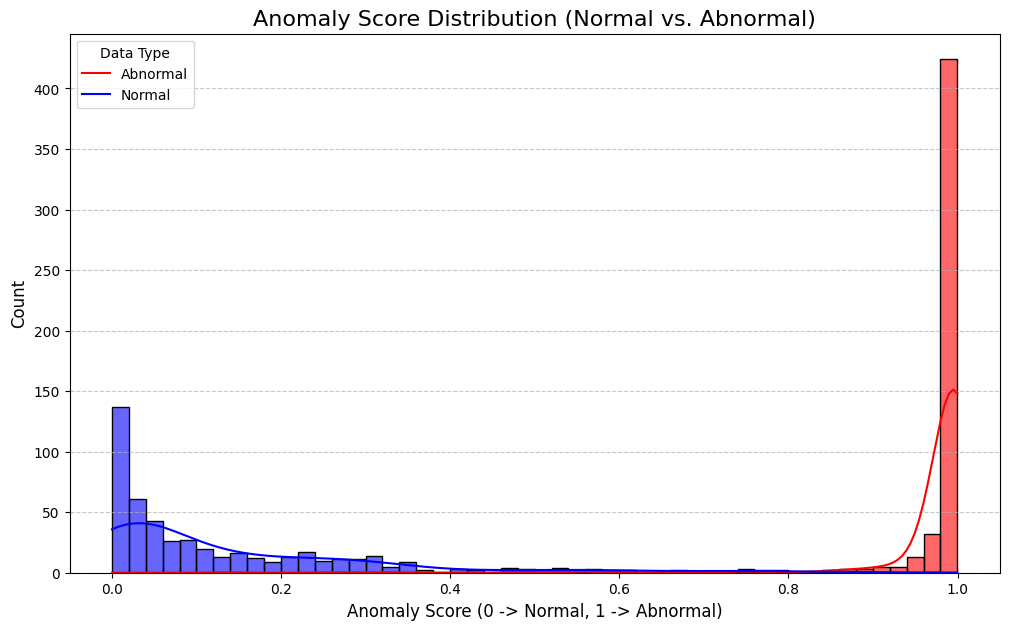

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings

N_SAMPLES = 500  # 測試樣本數量
test_data = []
test_labels = []

for _ in range(N_SAMPLES):
    test_data.append(normal_data_generator())
    test_labels.append(0) # 0 代表正常
for _ in range(N_SAMPLES):
    test_data.append(abnormal_data_generator())
    test_labels.append(1) # 1 代表異常

test_data_tensor = torch.from_numpy(np.array(test_data)).float().to(DEVICE)

# 將模型設為評估模式
model.eval()

all_scores = []
with torch.no_grad(): # 在推論時不需要計算梯度
    # 模型輸出的是 logits，需要通過 sigmoid 轉換成 0-1 之間的分數
    logits = model(test_data_tensor)
    scores = torch.sigmoid(logits).cpu().numpy().flatten()
    all_scores.extend(scores)

print(f"成功對 {len(all_scores)} 筆測試數據完成推論。")

# --- 步驟 5: 視覺化結果 ---
# 將結果整理成 Pandas DataFrame，方便繪圖
results_df = pd.DataFrame({
    'Anomaly Score': all_scores,
    'True Label': test_labels
})
results_df['Type'] = results_df['True Label'].map({0: 'Normal', 1: 'Abnormal'})

# 使用 seaborn 繪製直方圖
plt.figure(figsize=(12, 7))
sns.histplot(
    data=results_df,
    x='Anomaly Score',
    hue='Type',
    palette={'Normal': 'blue', 'Abnormal': 'red'},
    kde=True, # 加上核密度估計曲線，讓分佈更平滑
    bins=50,
    alpha=0.6
)

# 美化圖表
plt.title('Anomaly Score Distribution (Normal vs. Abnormal)', fontsize=16)
plt.xlabel('Anomaly Score (0 -> Normal, 1 -> Abnormal)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Data Type', labels=['Abnormal', 'Normal']) # 調整圖例順序以匹配顏色
plt.show()

# 各模型效果紀錄

# 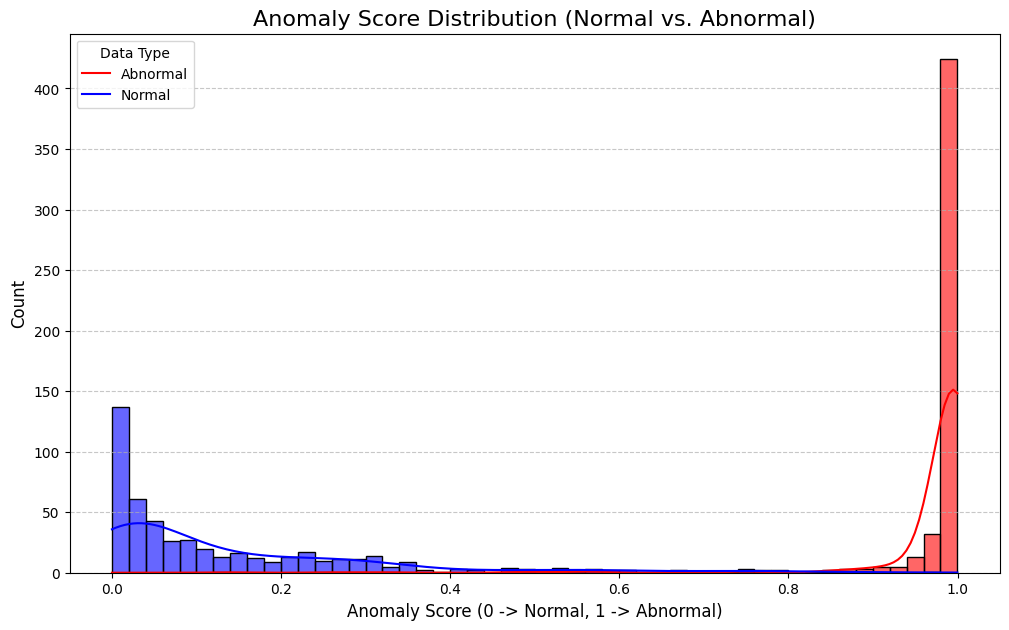

# 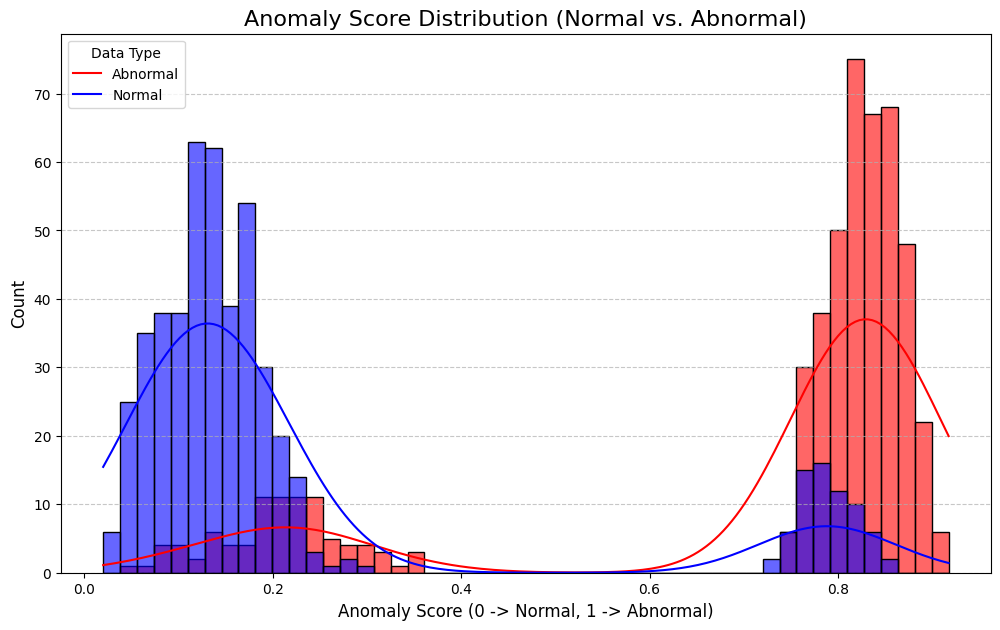

# 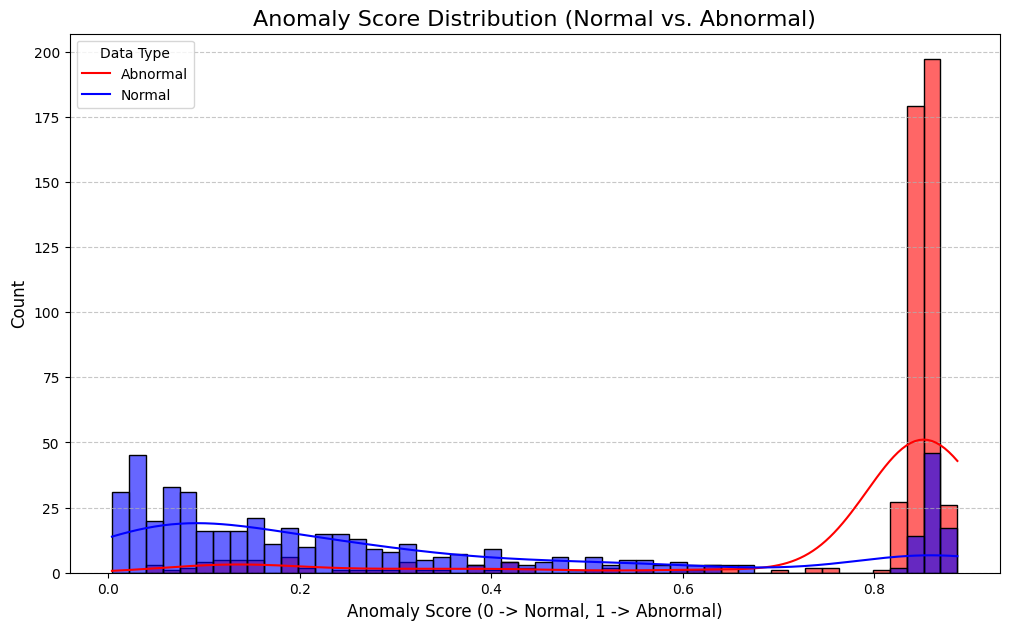

# 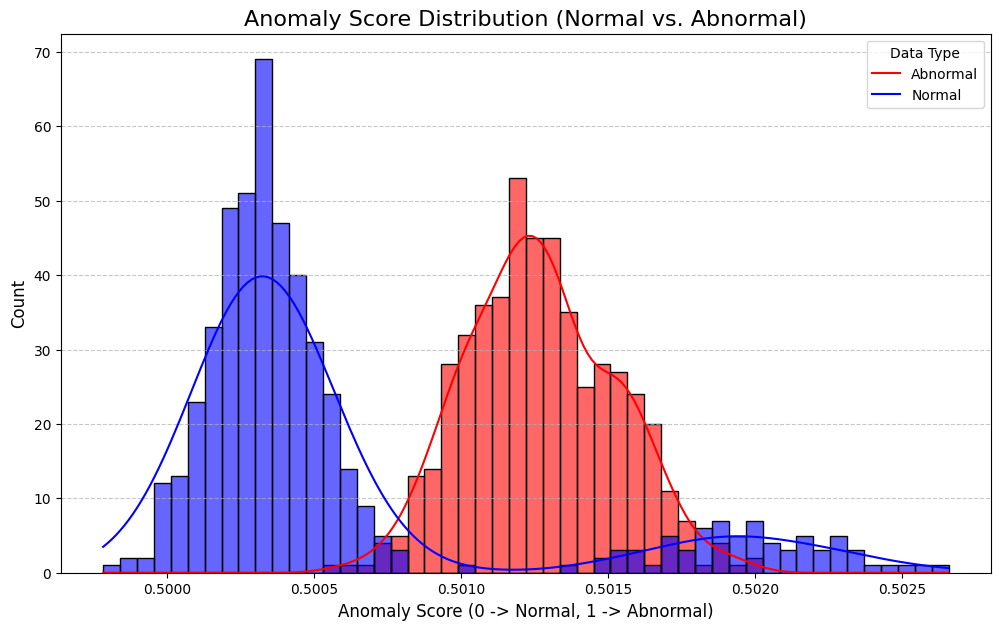

# 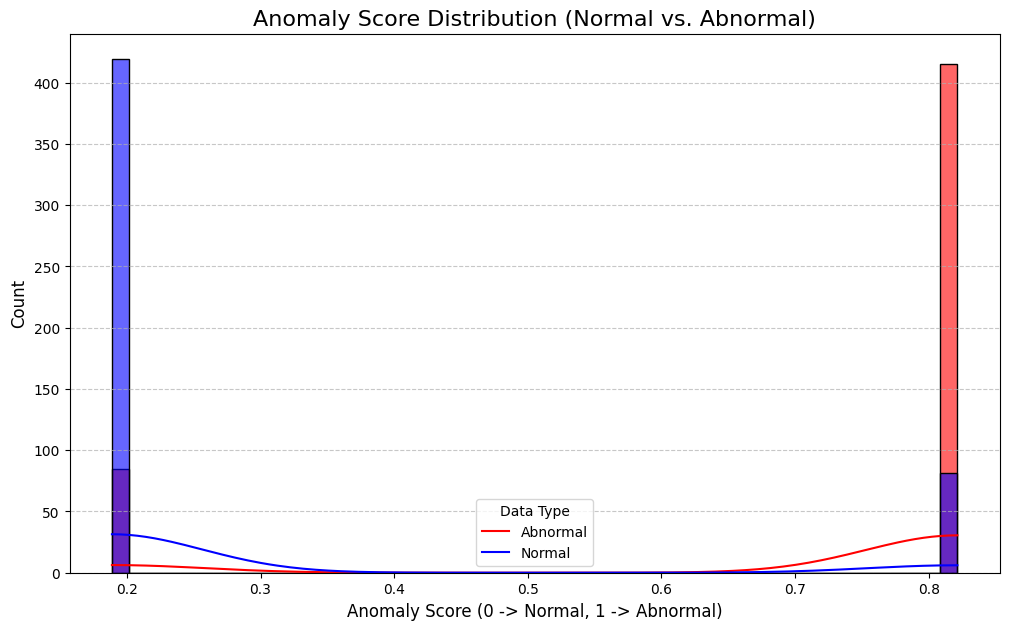

# 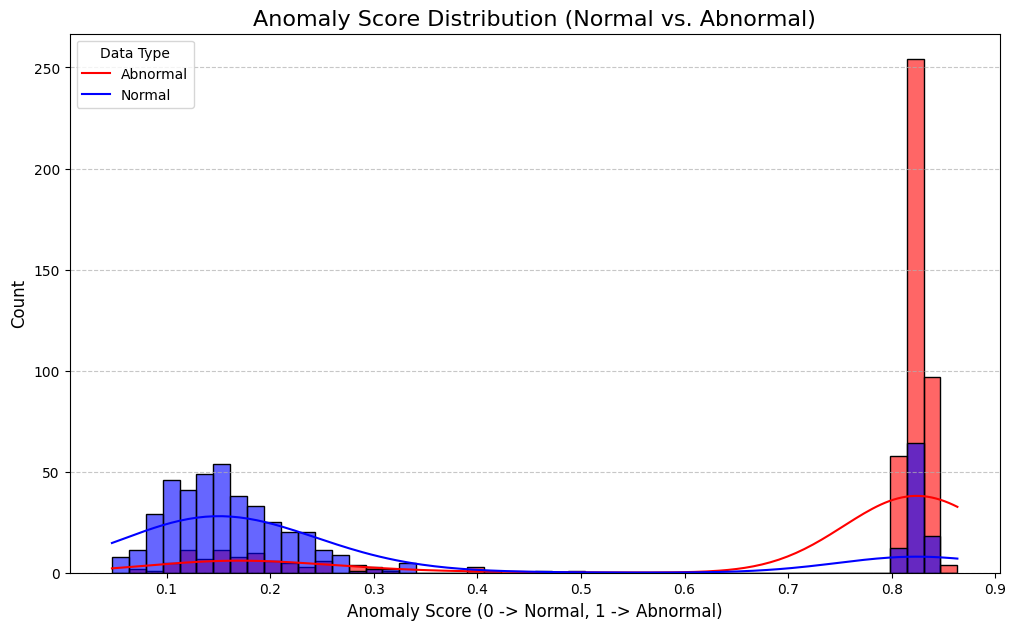

## E2E訓練

In [5]:
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# --- 參數設定 ---
BATCH_SIZE = 64
EPOCHS = 500
LEARNING_RATE = 1e-3
SEQUENCE_LENGTH = 130
WINDOW_SIZE = 32 # 從130個點中隨機抽取的窗口大小
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- 模型和優化器 ---
encoder = TSEncoder(input_dims=2, output_dims=128).to(DEVICE)
optimizer = torch.optim.Adam(encoder.parameters(), lr=LEARNING_RATE)

# --- 訓練循環 ---
encoder.train()
for epoch in range(EPOCHS):
    # 1. 生成一個 batch 的 "正常" 數據
    batch_data = np.array([normal_data_generator() for _ in range(BATCH_SIZE)])
    batch_data = torch.from_numpy(batch_data).float().to(DEVICE) # (Batch, Length, Channels)

    # 2. 為每個樣本創建兩個重疊的視圖 (view) 作為正樣本對
    # 這是數據增強/視圖生成的部分，是SSL的關鍵
    start_idx_i = np.random.randint(0, SEQUENCE_LENGTH - WINDOW_SIZE + 1)
    start_idx_j = np.random.randint(0, SEQUENCE_LENGTH - WINDOW_SIZE + 1)
    
    view_i = batch_data[:, start_idx_i : start_idx_i + WINDOW_SIZE, :]
    view_j = batch_data[:, start_idx_j : start_idx_j + WINDOW_SIZE, :]

    # 3. 清空梯度
    optimizer.zero_grad()
    
    # 4. 將兩個視圖傳入 Encoder 得到 embeddings
    z_i = encoder(view_i)
    z_j = encoder(view_j)
    
    # 5. 計算對比損失
    loss = nt_xent_loss(z_i, z_j, temperature=0.5)
    
    # 6. 反向傳播與優化
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}")

print("自監督預訓練完成！")
# 此時，encoder 已經學會了如何提取有意義的特徵
# torch.save(encoder.state_dict(), 'ssl_encoder.pth')

Epoch [10/500], Loss: 4.4264
Epoch [20/500], Loss: 4.2694
Epoch [30/500], Loss: 4.2974
Epoch [40/500], Loss: 4.0723
Epoch [50/500], Loss: 4.1774
Epoch [60/500], Loss: 4.0770
Epoch [70/500], Loss: 4.3823
Epoch [80/500], Loss: 4.6520
Epoch [90/500], Loss: 4.1692
Epoch [100/500], Loss: 3.6945
Epoch [110/500], Loss: 4.3411
Epoch [120/500], Loss: 4.5530
Epoch [130/500], Loss: 3.8826
Epoch [140/500], Loss: 4.0671
Epoch [150/500], Loss: 3.9830
Epoch [160/500], Loss: 3.5846
Epoch [170/500], Loss: 4.3847
Epoch [180/500], Loss: 3.6835
Epoch [190/500], Loss: 4.7372
Epoch [200/500], Loss: 4.4093
Epoch [210/500], Loss: 4.7413
Epoch [220/500], Loss: 4.7655
Epoch [230/500], Loss: 3.6435
Epoch [240/500], Loss: 3.6848
Epoch [250/500], Loss: 3.8675
Epoch [260/500], Loss: 3.5483
Epoch [270/500], Loss: 4.7178
Epoch [280/500], Loss: 3.6062
Epoch [290/500], Loss: 3.5177
Epoch [300/500], Loss: 3.4764
Epoch [310/500], Loss: 3.7912
Epoch [320/500], Loss: 3.7381
Epoch [330/500], Loss: 3.6319
Epoch [340/500], Lo

In [8]:
# --- 創建模型 ---
# --- 建立下游分類模型 ---
class AnomalyClassifier(nn.Module):
    def __init__(self, pretrained_encoder):
        super().__init__()
        self.encoder = pretrained_encoder
        # 凍結 Encoder 的權重
        for param in self.encoder.parameters():
            param.requires_grad = False
            
        self.classifier_head = nn.Linear(128, 1) # 輸出一個logit，用於二元分類

    def forward(self, x):
        # 用預訓練好的 encoder 提取特徵
        features = self.encoder(x) # 注意：這裡的 encoder 輸出的是 projector 之後的 embedding
        # 分類
        output = self.classifier_head(features)
        return output
model = AnomalyClassifier(encoder).to(DEVICE)

# --- 準備標籤數據進行微調 ---
X_train_labeled = []
y_train_labeled = []
for _ in range(200): # 假設有400筆標籤數據
    X_train_labeled.append(normal_data_generator())
    y_train_labeled.append(0)
    X_train_labeled.append(abnormal_data_generator())
    y_train_labeled.append(1)

X_train_tensor = torch.from_numpy(np.array(X_train_labeled)).float().to(DEVICE)
y_train_tensor = torch.from_numpy(np.array(y_train_labeled)).float().view(-1, 1).to(DEVICE)

# --- 核心改動：創建帶有差分學習率的優化器 ---
# 為 Encoder 設置一個非常小的學習率 (e.g., 1e-5)
# 為分類頭設置一個正常的學習率 (e.g., 1e-3)
optimizer_ft = torch.optim.Adam([
    {'params': model.encoder.parameters(), 'lr': 1e-5},
    {'params': model.classifier_head.parameters(), 'lr': 1e-3}
], lr=1e-3) # 這裡的 lr 是預設值，會被字典中的值覆蓋

criterion = nn.BCEWithLogitsLoss()

# --- 微調訓練循環 (與之前完全相同) ---
model.train()
for epoch in range(EPOCHS): # 微調 epoch 不需要太多
    optimizer_ft.zero_grad()
    predictions = model(X_train_tensor) 
    loss = criterion(predictions, y_train_tensor)
    loss.backward()
    optimizer_ft.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}")

print("自監督預訓練完成！")

Epoch [10/500], Loss: 0.5854
Epoch [20/500], Loss: 0.5436
Epoch [30/500], Loss: 0.5371
Epoch [40/500], Loss: 0.5286
Epoch [50/500], Loss: 0.5219
Epoch [60/500], Loss: 0.5134
Epoch [70/500], Loss: 0.5131
Epoch [80/500], Loss: 0.4976
Epoch [90/500], Loss: 0.4935
Epoch [100/500], Loss: 0.4888
Epoch [110/500], Loss: 0.4846
Epoch [120/500], Loss: 0.4818
Epoch [130/500], Loss: 0.4803
Epoch [140/500], Loss: 0.4781
Epoch [150/500], Loss: 0.4692
Epoch [160/500], Loss: 0.4617
Epoch [170/500], Loss: 0.4638
Epoch [180/500], Loss: 0.4625
Epoch [190/500], Loss: 0.4549
Epoch [200/500], Loss: 0.4601
Epoch [210/500], Loss: 0.4499
Epoch [220/500], Loss: 0.4471
Epoch [230/500], Loss: 0.4499
Epoch [240/500], Loss: 0.4518
Epoch [250/500], Loss: 0.4574
Epoch [260/500], Loss: 0.4445
Epoch [270/500], Loss: 0.4406
Epoch [280/500], Loss: 0.4469
Epoch [290/500], Loss: 0.4419
Epoch [300/500], Loss: 0.4419
Epoch [310/500], Loss: 0.4429
Epoch [320/500], Loss: 0.4414
Epoch [330/500], Loss: 0.4366
Epoch [340/500], Lo

成功對 1000 筆測試數據完成推論。


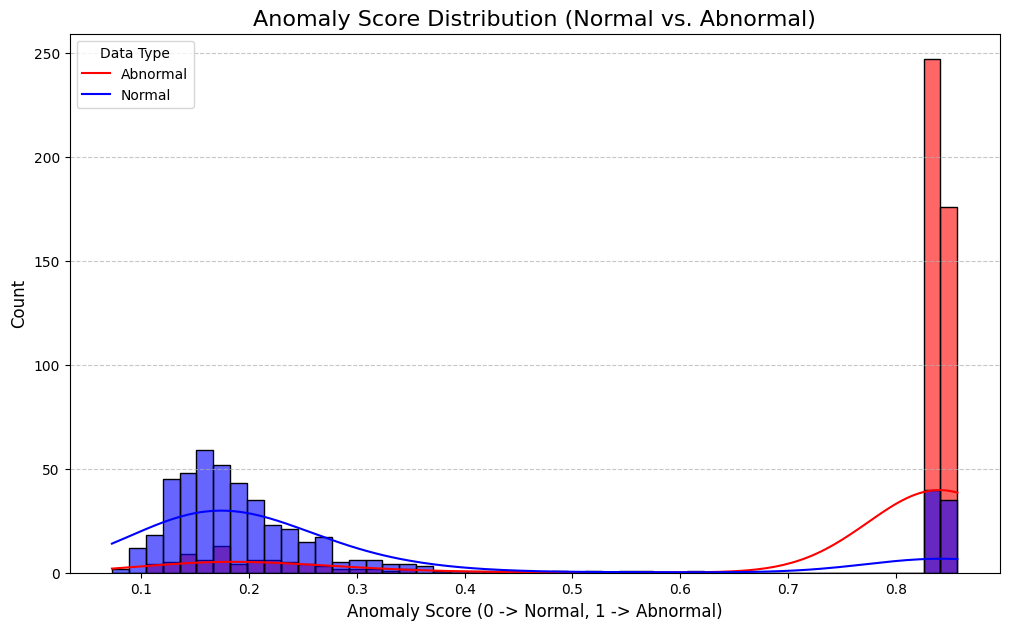

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings

N_SAMPLES = 500  # 測試樣本數量
test_data = []
test_labels = []

for _ in range(N_SAMPLES):
    test_data.append(normal_data_generator())
    test_labels.append(0) # 0 代表正常
for _ in range(N_SAMPLES):
    test_data.append(abnormal_data_generator())
    test_labels.append(1) # 1 代表異常

test_data_tensor = torch.from_numpy(np.array(test_data)).float().to(DEVICE)

# 將模型設為評估模式
model.eval()

all_scores = []
with torch.no_grad(): # 在推論時不需要計算梯度
    # 模型輸出的是 logits，需要通過 sigmoid 轉換成 0-1 之間的分數
    logits = model(test_data_tensor)
    scores = torch.sigmoid(logits).cpu().numpy().flatten()
    all_scores.extend(scores)

print(f"成功對 {len(all_scores)} 筆測試數據完成推論。")

# --- 步驟 5: 視覺化結果 ---
# 將結果整理成 Pandas DataFrame，方便繪圖
results_df = pd.DataFrame({
    'Anomaly Score': all_scores,
    'True Label': test_labels
})
results_df['Type'] = results_df['True Label'].map({0: 'Normal', 1: 'Abnormal'})

# 使用 seaborn 繪製直方圖
plt.figure(figsize=(12, 7))
sns.histplot(
    data=results_df,
    x='Anomaly Score',
    hue='Type',
    palette={'Normal': 'blue', 'Abnormal': 'red'},
    kde=True, # 加上核密度估計曲線，讓分佈更平滑
    bins=50,
    alpha=0.6
)

# 美化圖表
plt.title('Anomaly Score Distribution (Normal vs. Abnormal)', fontsize=16)
plt.xlabel('Anomaly Score (0 -> Normal, 1 -> Abnormal)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Data Type', labels=['Abnormal', 'Normal']) # 調整圖例順序以匹配顏色
plt.show()

# 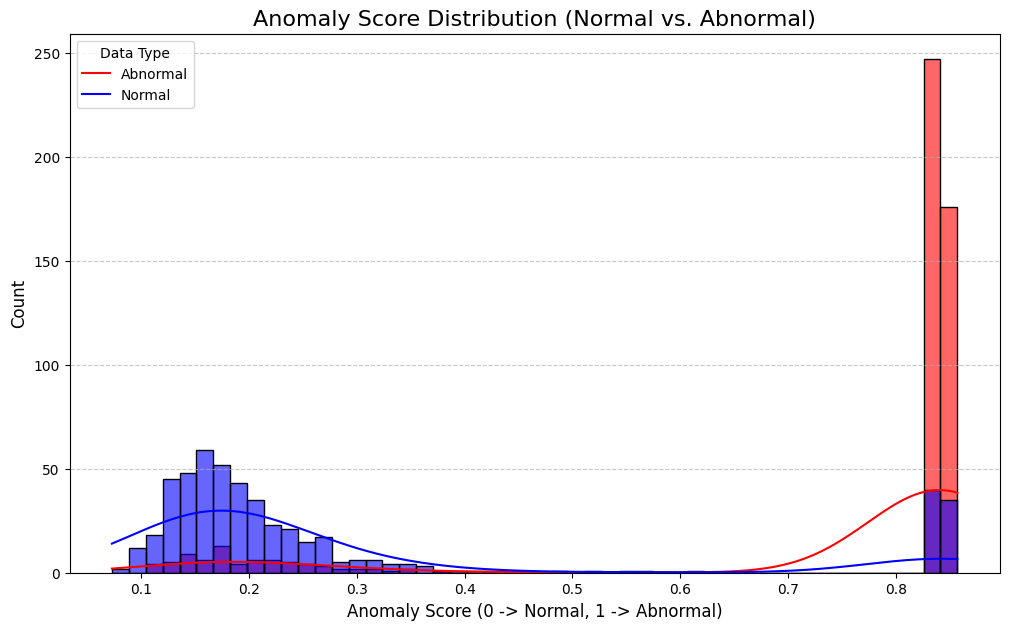

## Barlow Twins Loss

In [5]:
def barlow_twins_loss(z_i, z_j, lambda_param=5e-3):
    """
    Barlow Twins Loss 的實現
    z_i, z_j: 正樣本對的 embeddings, shape: [batch_size, embedding_dim]
    """
    batch_size, embedding_dim = z_i.size()

    # 1. 對 embedding 進行標準化
    z_i_norm = (z_i - z_i.mean(0)) / z_i.std(0)
    z_j_norm = (z_j - z_j.mean(0)) / z_j.std(0)

    # 2. 計算交叉相關矩陣
    # c shape: (embedding_dim, embedding_dim)
    c = torch.matmul(z_i_norm.T, z_j_norm) / batch_size

    # 3. 計算損失
    on_diag = torch.diagonal(c).add_(-1).pow_(2).sum()
    off_diag = c.flatten()[:-1].view(embedding_dim - 1, embedding_dim + 1)[:, 1:].flatten().pow_(2).sum()
    
    loss = on_diag + lambda_param * off_diag
    return loss

In [7]:
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# --- 參數設定 ---
BATCH_SIZE = 64
EPOCHS = 500
LEARNING_RATE = 1e-3
SEQUENCE_LENGTH = 130
WINDOW_SIZE = 32 # 從130個點中隨機抽取的窗口大小
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- 模型和優化器 ---
encoder = TSEncoder(input_dims=2, output_dims=128).to(DEVICE)
optimizer = torch.optim.Adam(encoder.parameters(), lr=LEARNING_RATE)

# --- 訓練循環 ---
encoder.train()
for epoch in range(EPOCHS):
    # 1. 生成一個 batch 的 "正常" 數據
    batch_data = np.array([normal_data_generator() for _ in range(BATCH_SIZE)])
    batch_data = torch.from_numpy(batch_data).float().to(DEVICE) # (Batch, Length, Channels)

    # 2. 為每個樣本創建兩個重疊的視圖 (view) 作為正樣本對
    # 這是數據增強/視圖生成的部分，是SSL的關鍵
    start_idx_i = np.random.randint(0, SEQUENCE_LENGTH - WINDOW_SIZE + 1)
    start_idx_j = np.random.randint(0, SEQUENCE_LENGTH - WINDOW_SIZE + 1)
    
    view_i = batch_data[:, start_idx_i : start_idx_i + WINDOW_SIZE, :]
    view_j = batch_data[:, start_idx_j : start_idx_j + WINDOW_SIZE, :]

    # 3. 清空梯度
    optimizer.zero_grad()
    
    # 4. 將兩個視圖傳入 Encoder 得到 embeddings
    z_i = encoder(view_i)
    z_j = encoder(view_j)
    
    # 5. 計算對比損失
    loss = barlow_twins_loss(z_i, z_j)
    
    # 6. 反向傳播與優化
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}")

print("自監督預訓練完成！")
# 此時，encoder 已經學會了如何提取有意義的特徵
# torch.save(encoder.state_dict(), 'ssl_encoder.pth')

Epoch [10/500], Loss: 57.8218
Epoch [20/500], Loss: 89.5853
Epoch [30/500], Loss: 48.8581
Epoch [40/500], Loss: 42.5654
Epoch [50/500], Loss: 32.5193
Epoch [60/500], Loss: 36.3070
Epoch [70/500], Loss: 35.8378
Epoch [80/500], Loss: 35.2382
Epoch [90/500], Loss: 31.4427
Epoch [100/500], Loss: 50.6277
Epoch [110/500], Loss: 32.7097
Epoch [120/500], Loss: 70.3516
Epoch [130/500], Loss: 42.0801
Epoch [140/500], Loss: 62.6247
Epoch [150/500], Loss: 30.0382
Epoch [160/500], Loss: 28.3127
Epoch [170/500], Loss: 27.7133
Epoch [180/500], Loss: 56.4523
Epoch [190/500], Loss: 39.8218
Epoch [200/500], Loss: 25.6855
Epoch [210/500], Loss: 25.2644
Epoch [220/500], Loss: 24.0997
Epoch [230/500], Loss: 26.5619
Epoch [240/500], Loss: 24.2358
Epoch [250/500], Loss: 23.9189
Epoch [260/500], Loss: 48.7935
Epoch [270/500], Loss: 33.0373
Epoch [280/500], Loss: 60.2884
Epoch [290/500], Loss: 51.7654
Epoch [300/500], Loss: 54.6315
Epoch [310/500], Loss: 30.5883
Epoch [320/500], Loss: 26.3586
Epoch [330/500], 

In [8]:
# --- 建立下游分類模型 ---
class AnomalyClassifier(nn.Module):
    def __init__(self, pretrained_encoder):
        super().__init__()
        self.encoder = pretrained_encoder
        # 凍結 Encoder 的權重
        for param in self.encoder.parameters():
            param.requires_grad = False
            
        self.classifier_head = nn.Linear(128, 1) # 輸出一個logit，用於二元分類

    def forward(self, x):
        # 用預訓練好的 encoder 提取特徵
        features = self.encoder(x) # 注意：這裡的 encoder 輸出的是 projector 之後的 embedding
        # 分類
        output = self.classifier_head(features)
        return output

# --- 準備標籤數據進行微調 ---
# 假設我們有一些標籤數據
X_train_labeled = []
y_train_labeled = []
for _ in range(200): # 假設有400筆標籤數據
    X_train_labeled.append(normal_data_generator())
    y_train_labeled.append(0)
    X_train_labeled.append(abnormal_data_generator())
    y_train_labeled.append(1)

X_train_tensor = torch.from_numpy(np.array(X_train_labeled)).float().to(DEVICE)
y_train_tensor = torch.from_numpy(np.array(y_train_labeled)).float().view(-1, 1).to(DEVICE)

# --- 微調訓練 ---
# 載入預訓練好的 encoder
# encoder.load_state_dict(torch.load('ssl_encoder.pth'))

model = AnomalyClassifier(encoder).to(DEVICE)
optimizer_ft = torch.optim.Adam(model.classifier_head.parameters(), lr=1e-3) # 只優化分類頭
criterion = nn.BCEWithLogitsLoss() # 帶 sigmoid 的二元交叉熵損失

model.train()
for epoch in range(EPOCHS): # 微調通常很快
    optimizer_ft.zero_grad()
    predictions = model(X_train_tensor) # 注意：這裡輸入的是完整長度序列
    loss = criterion(predictions, y_train_tensor)
    loss.backward()
    optimizer_ft.step()
    print(f"Fine-tune Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}")

print("下游任務微調完成！模型現在可以用於異常偵測。")

Fine-tune Epoch [1/500], Loss: 0.6974
Fine-tune Epoch [2/500], Loss: 0.6750
Fine-tune Epoch [3/500], Loss: 0.6500
Fine-tune Epoch [4/500], Loss: 0.6357
Fine-tune Epoch [5/500], Loss: 0.6202
Fine-tune Epoch [6/500], Loss: 0.6027
Fine-tune Epoch [7/500], Loss: 0.5870
Fine-tune Epoch [8/500], Loss: 0.5678
Fine-tune Epoch [9/500], Loss: 0.5539
Fine-tune Epoch [10/500], Loss: 0.5446
Fine-tune Epoch [11/500], Loss: 0.5314
Fine-tune Epoch [12/500], Loss: 0.5185
Fine-tune Epoch [13/500], Loss: 0.5081
Fine-tune Epoch [14/500], Loss: 0.5020
Fine-tune Epoch [15/500], Loss: 0.4912
Fine-tune Epoch [16/500], Loss: 0.4829
Fine-tune Epoch [17/500], Loss: 0.4738
Fine-tune Epoch [18/500], Loss: 0.4659
Fine-tune Epoch [19/500], Loss: 0.4585
Fine-tune Epoch [20/500], Loss: 0.4526
Fine-tune Epoch [21/500], Loss: 0.4477
Fine-tune Epoch [22/500], Loss: 0.4377
Fine-tune Epoch [23/500], Loss: 0.4361
Fine-tune Epoch [24/500], Loss: 0.4315
Fine-tune Epoch [25/500], Loss: 0.4273
Fine-tune Epoch [26/500], Loss: 0.

Fine-tune Epoch [270/500], Loss: 0.3692
Fine-tune Epoch [271/500], Loss: 0.3707
Fine-tune Epoch [272/500], Loss: 0.3734
Fine-tune Epoch [273/500], Loss: 0.3740
Fine-tune Epoch [274/500], Loss: 0.3817
Fine-tune Epoch [275/500], Loss: 0.3721
Fine-tune Epoch [276/500], Loss: 0.3681
Fine-tune Epoch [277/500], Loss: 0.3704
Fine-tune Epoch [278/500], Loss: 0.3725
Fine-tune Epoch [279/500], Loss: 0.3697
Fine-tune Epoch [280/500], Loss: 0.3677
Fine-tune Epoch [281/500], Loss: 0.3761
Fine-tune Epoch [282/500], Loss: 0.3757
Fine-tune Epoch [283/500], Loss: 0.3731
Fine-tune Epoch [284/500], Loss: 0.3763
Fine-tune Epoch [285/500], Loss: 0.3748
Fine-tune Epoch [286/500], Loss: 0.3798
Fine-tune Epoch [287/500], Loss: 0.3751
Fine-tune Epoch [288/500], Loss: 0.3705
Fine-tune Epoch [289/500], Loss: 0.3704
Fine-tune Epoch [290/500], Loss: 0.3650
Fine-tune Epoch [291/500], Loss: 0.3697
Fine-tune Epoch [292/500], Loss: 0.3675
Fine-tune Epoch [293/500], Loss: 0.3787
Fine-tune Epoch [294/500], Loss: 0.3709


成功對 1000 筆測試數據完成推論。


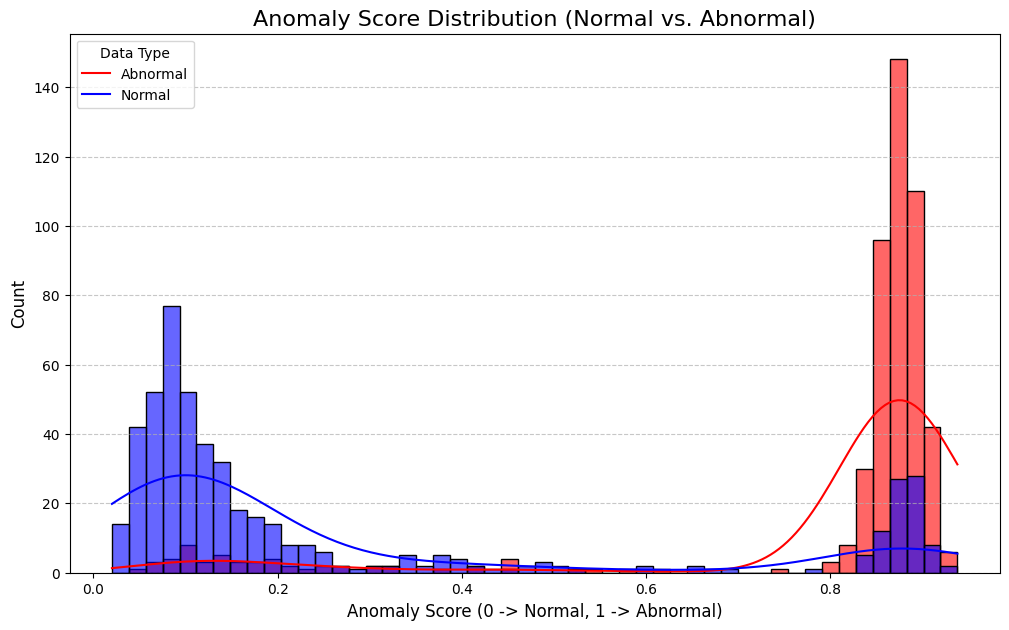

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings

N_SAMPLES = 500  # 測試樣本數量
test_data = []
test_labels = []

for _ in range(N_SAMPLES):
    test_data.append(normal_data_generator())
    test_labels.append(0) # 0 代表正常
for _ in range(N_SAMPLES):
    test_data.append(abnormal_data_generator())
    test_labels.append(1) # 1 代表異常

test_data_tensor = torch.from_numpy(np.array(test_data)).float().to(DEVICE)

# 將模型設為評估模式
model.eval()

all_scores = []
with torch.no_grad(): # 在推論時不需要計算梯度
    # 模型輸出的是 logits，需要通過 sigmoid 轉換成 0-1 之間的分數
    logits = model(test_data_tensor)
    scores = torch.sigmoid(logits).cpu().numpy().flatten()
    all_scores.extend(scores)

print(f"成功對 {len(all_scores)} 筆測試數據完成推論。")

# --- 步驟 5: 視覺化結果 ---
# 將結果整理成 Pandas DataFrame，方便繪圖
results_df = pd.DataFrame({
    'Anomaly Score': all_scores,
    'True Label': test_labels
})
results_df['Type'] = results_df['True Label'].map({0: 'Normal', 1: 'Abnormal'})

# 使用 seaborn 繪製直方圖
plt.figure(figsize=(12, 7))
sns.histplot(
    data=results_df,
    x='Anomaly Score',
    hue='Type',
    palette={'Normal': 'blue', 'Abnormal': 'red'},
    kde=True, # 加上核密度估計曲線，讓分佈更平滑
    bins=50,
    alpha=0.6
)

# 美化圖表
plt.title('Anomaly Score Distribution (Normal vs. Abnormal)', fontsize=16)
plt.xlabel('Anomaly Score (0 -> Normal, 1 -> Abnormal)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Data Type', labels=['Abnormal', 'Normal']) # 調整圖例順序以匹配顏色
plt.show()

# 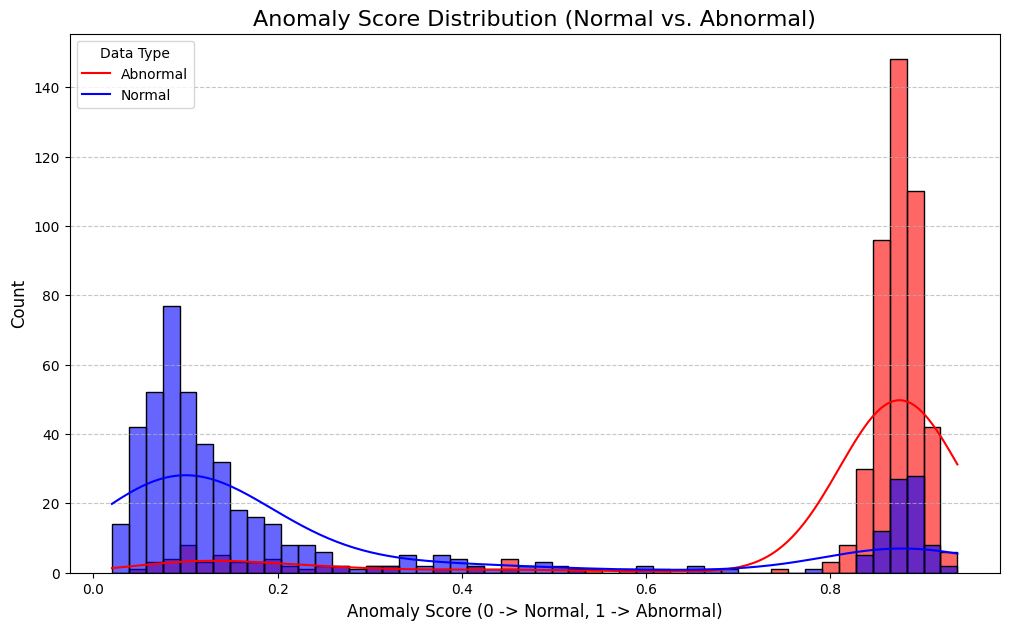